<a href="https://colab.research.google.com/github/geomyll33/Beautez/blob/master/RNN_huber_learningrate_optimiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [17]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

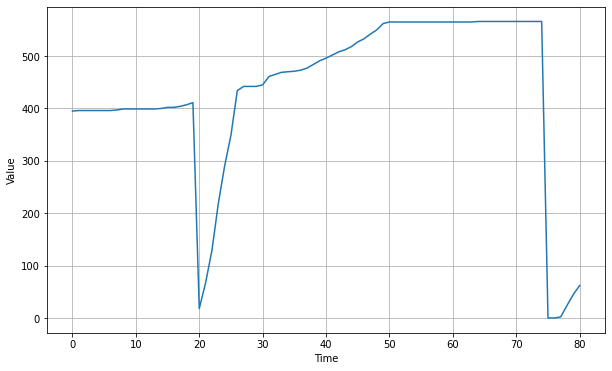

In [18]:
import csv
time_step = []
temps = []

with open('/content/ευδαπ_dataset_527085.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

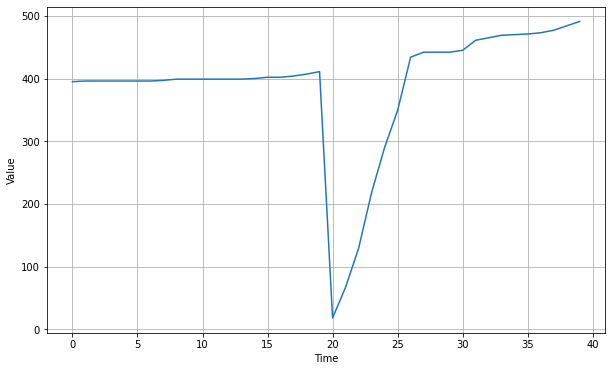

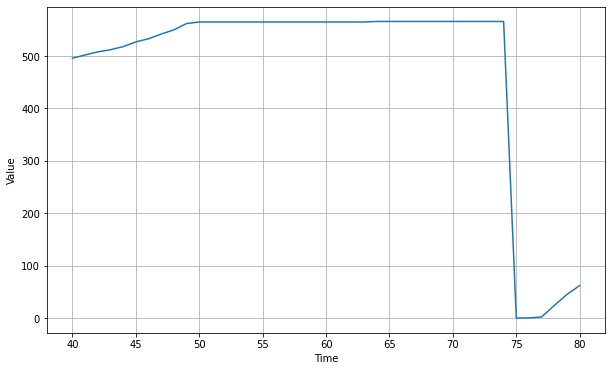

In [25]:
split_time = 40
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 3
batch_size = 2
shuffle_buffer_size = 3
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [37]:
tf.keras.backend.clear_session()
tf.random.set_seed(21)
np.random.seed(21)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 224.1910 - mae: 224.6910
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 223.9429 - mae: 224.4429
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 223.4439 - mae: 223.9439
Epoch 4/100
1/1 [==============================] - 0s 15ms/step - loss: 222.7004 - mae: 223.2004
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 221.7498 - mae: 222.2498
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 220.6890 - mae: 221.1890
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 219.6809 - mae: 220.1809
Epoch 8/100
1/1 [==============================] - 0s 18ms/step - loss: 218.8960 - mae: 219.3960
Epoch 9/100
1/1 [==============================] - 0s 23ms/step - loss: 218.4115 - mae: 218.9115
Epoch 10/100
1/1 [==============================] - 0s 19ms/step - loss: 218.1814 - mae: 218.6814
Epoch 11/100
1/1 [=============

(1e-08, 0.0001, 0.0, 200.0)

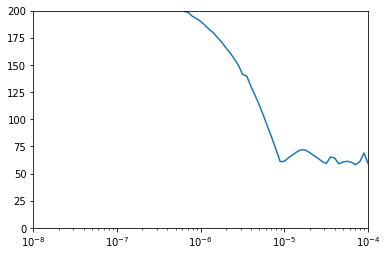

In [39]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 200])

In [40]:
tf.keras.backend.clear_session()
tf.random.set_seed(21)
np.random.seed(21)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
1/1 [==============================] - 1s 1s/step - loss: 224.1910 - mae: 224.6910
Epoch 2/400
1/1 [==============================] - 0s 16ms/step - loss: 214.1811 - mae: 214.6811
Epoch 3/400
1/1 [==============================] - 0s 16ms/step - loss: 200.4473 - mae: 200.9473
Epoch 4/400
1/1 [==============================] - 0s 20ms/step - loss: 195.6059 - mae: 196.1059
Epoch 5/400
1/1 [==============================] - 0s 15ms/step - loss: 176.3889 - mae: 176.8889
Epoch 6/400
1/1 [==============================] - 0s 16ms/step - loss: 154.5952 - mae: 155.0952
Epoch 7/400
1/1 [==============================] - 0s 13ms/step - loss: 131.5623 - mae: 132.0623
Epoch 8/400
1/1 [==============================] - 0s 16ms/step - loss: 109.6449 - mae: 110.1449
Epoch 9/400
1/1 [==============================] - 0s 24ms/step - loss: 88.6013 - mae: 89.1013
Epoch 10/400
1/1 [==============================] - 0s 15ms/step - loss: 69.7150 - mae: 70.2150
Epoch 11/400
1/1 [=================

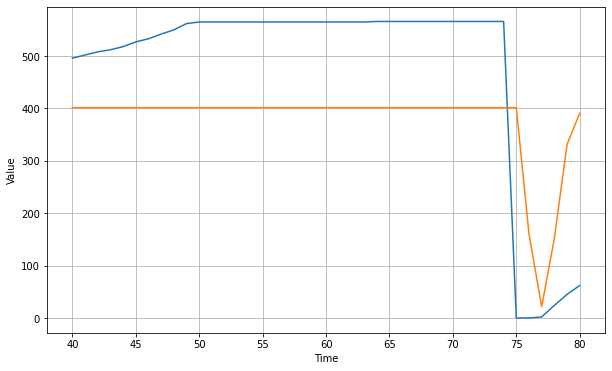

In [41]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [42]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

162.40833

<Figure size 432x288 with 0 Axes>

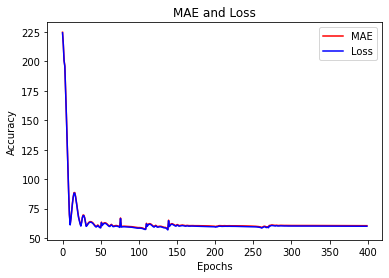

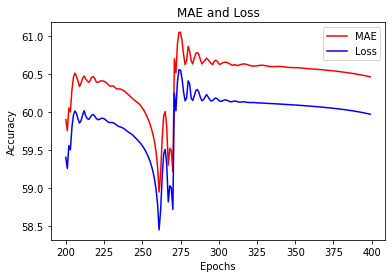

<Figure size 432x288 with 0 Axes>

In [43]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()